In [107]:
!pip install -q pytorch.ignite
!pip install -q torch
!pip install -q lasio
!pip install -q -U petrolib

In [108]:
import os
import lasio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from numpy import Inf, sqrt
from tqdm.auto import tqdm

import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import torch
from torch import nn
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from ignite.contrib.metrics.regression.r2_score import R2Score

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline
%config BackendInline.figure_format = 'retina'
pd.options.display.max_columns = 23

In [109]:
print(f'pandas version : {pd.__version__}')
print(f'numpy version : {np.__version__}')
print(f'scikit learn version : {sklearn.__version__}')
print(f'seaborn version : {sns.__version__}')
print(f'matplotlib version : {matplotlib.__version__}')
print(f'torch version : {torch.__version__}')
print(f'lasio version : {lasio.version()}')

pandas version : 1.5.3
numpy version : 1.25.2
scikit learn version : 1.2.2
seaborn version : 0.13.1
matplotlib version : 3.7.1
torch version : 2.2.1+cu121
lasio version : 0.31


In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [111]:
#select columns to use in the dataframe
col = ['NPHI', 'RHOB', 'GR', 'RT','DT', 'DTS', 'DEPTH']
f_cols = ['DEPTH', 'WELL', 'GR', 'RT', 'RHOB', 'NPHI', 'DTC', 'DTS']

def process_train(well, cols, name):

    '''
    cleans and process the train dataframe for null values

    '''
#     column = cols[:-2]
    df = well.filter(cols, axis='columns')
    df = df.dropna(axis='index',
                   subset=['NPHI','DTS', 'DT']).rename({'DT':'DTC'},
                                                       axis='columns').reset_index(drop=True).sort_values('DEPTH')
    df['WELL'] = name

    return df[f_cols]

def process_test(well, cols, name):

    '''
    cleans and process the test dataframe for null values

    '''
#     column = cols[:-2]
    if name == '15_9-F-5' or name == '15_9-F-15D':
        column = ['NPHI', 'RHOB', 'GR', 'RT', 'DEPTH']
        df = well.filter(column, axis='columns')
        df = df.dropna(axis='index', subset=['NPHI']).reset_index(drop=True).sort_values('DEPTH')
        # df_shape = df.shape
        df['WELL'] = name

        if name =='15_9-F-5':
            df['DEPTH'] = round((df['DEPTH']*0.0254)/10, 1)

        return df[f_cols[:6]]

    else:
        df = well.filter(cols, axis='columns')
        df = df.dropna(axis='index',
                       subset=['DTS', 'DT']).rename({'DT':'DTC'},
                                                           axis='columns').reset_index(drop=True).sort_values('DEPTH')
        df['WELL'] = name
        df['NPHI'] = np.where(df['NPHI'] < 0, np.nan, df['NPHI'])
        df = df.dropna().reset_index(drop=True)#well2
        if name == '15_9-F-14' or name == '15_9-F-4':

            df['DEPTH'] = round((df['DEPTH']*0.0254)/10, 1)


        return df[f_cols]


# Data Loading and Processing

In [112]:
# get all paths and alphabetically ordered
# paths = sorted(glob.glob(os.path.join("./", "*.LAS")))
paths = ['15_9-F-11A.LAS', '15_9-F-11T2.LAS', '15_9-F-1A.LAS', '15_9-F-1B.LAS',
         '15_9-F-4.LAS', '15_9-F-14.LAS', '15_9-F-5.LAS', '15_9-F-15D.LAS']
well_df = [0] * 8

for i in range(len(paths)):
    # read with lasio and convert to dataframe
    df = (lasio.read(os.path.join("/content/drive/My Drive/sonic_log/1d-cnn-for-sonic-log-prediction/data/", paths[i]))).df()

    well_df[i] = df.reset_index()

well1, well2, well3, well4, well5, well6, well7, well8 = well_df

In [113]:
well1 = process_train(well1, col, name='15_9-F-11A')
well2 = process_test(well2, col, name='15_9-F-11T2') #validation
well3 = process_train(well3, col, name='15_9-F-1A')
well4 = process_train(well4, col, name='15_9-F-1B')
well5 = process_test(well5, col, name='15_9-F-4') #validation
# well6 = process_test(well6, col, name='15_9-F-14') #blind test
well7 = process_test(well7, col, name='15_9-F-5') #blind
well8 = process_test(well8, col, name='15_9-F-15D') #blind

In [114]:
train = pd.concat((well1, well3, well4), axis='index').reset_index(drop=True)
test = pd.concat((well2, well5), axis='index').reset_index(drop=True)
test2 = pd.concat((well7, well8), axis='index').reset_index(drop=True)

# Correlation Plot

<Axes: >

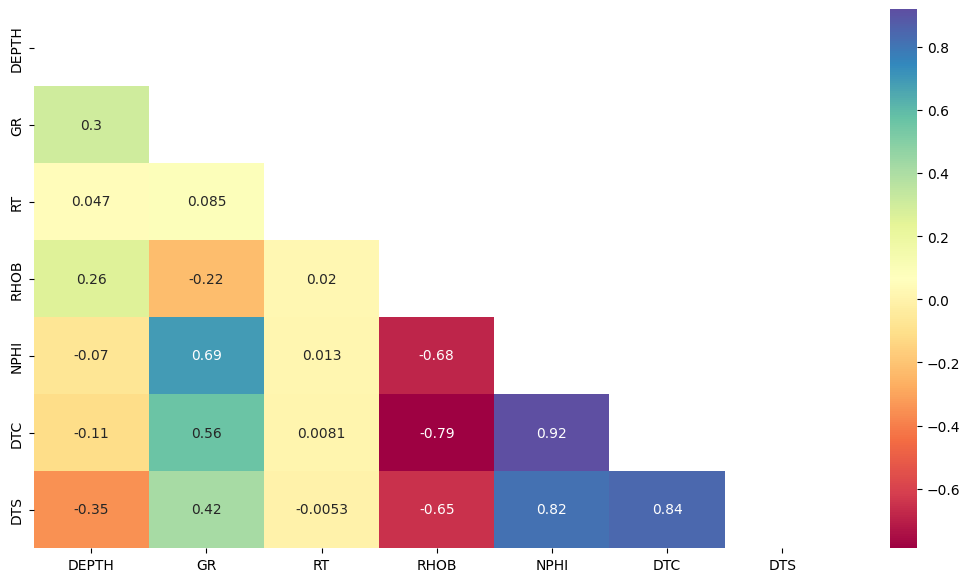

In [115]:
plt.figure(figsize=((13, 7)))
corr = train.select_dtypes('float64').corr()
mask_triangle=np.triu(np.ones(corr.shape)).astype(bool)
sns.heatmap(corr, mask=mask_triangle, annot=True, cmap='Spectral')

In [116]:
from scipy.stats.stats import pearsonr
class Correlation:

    r"""
    A correlation class for pearson and chatterjee method of statistical significance.

    Parameters
    ----------

    df : pd.DataFrame
        Takes in only the dataframe


    """
    def __init__(self, dataframe:pd.DataFrame):

        self._df = dataframe


    def _chatterjee(self, x:pd.Series, y:pd.Series) -> float:
        '''
        A private method that implements chatterjee method

        Return
        ------
        correlation between two variable
        '''
        df = pd.DataFrame()
        df['x_rk'] = x.rank()
        df['y_rk'] = y.rank()
        df = df.sort_values('x_rk')
        sum_term = df['y_rk'].diff().abs().sum()
        chatt_corr = (1 - 3 * sum_term / (pow(df.shape[0], 2) - 1))

        return chatt_corr

    def corr(self, method:str='chatterjee'):

        r'''

        Function to calculate the linear (Pearson's) and non-linear (Chatterjee's) relationships between log curves.
        Relationship between well logs are usually non-linear.

        Parameters
        ----------

        method : str, default 'chatterjee'
              Method of correlation. {'chatterjee', 'pearsonr', 'linear', 'nonlinear'}

              * 'linear' is the same as 'pearsonr'
              * 'nonlinear' is the same as 'chatterjee'

        Returns
        -------
        Correlation matrix of all possible log curves combination

        Example
        -------
         >>> corr = Correlation(df)
         >>> v = corr.corr(method='chatterjee)

        '''

        self._method = method
        X = self._df.columns.tolist()
        Y = X.copy()

        df = pd.DataFrame(index=X, columns=Y)

        for i in X:
            for j in Y:
                if method == 'chatterjee' or method == 'nonlinear':
                    corr = self._chatterjee(self._df[i], self._df[j])
                    df[i][j] = corr
                elif method=='pearsonr' or method == 'linear':
                    self._df = self._df.dropna()
                    corr, _ = pearsonr(self._df[i], self._df[j])
                    df[i][j] = corr

        #convert the columns to numeric from object
        for column in df.columns:

            df[column] = df[column].astype(np.float32)

        return df


    def plot_heatmap(self, title:str='Correlation Heatmap with Chatterjee', figsize:tuple=(12, 7), annot:bool=True, cmap=None):

        r'''
        Plots the heat map of Correlation Matrix

        Parameters
        ----------
        title : str
            Title of plot

        figsize : tuple
            Size of plot

        annot : bool, default True
            To annotate the coefficient in the plot

        cmap : matplotlib colormap name or object, or list of colors, optional
            The mapping from data values to color space

        Example
        -------
         >>> corr = Correlation(df)
         >>> v = corr.corr(method='chatterjee)
         >>> corr.plot_heatmap(cmap='Reds')

        '''

        corr = self.corr(self._method)
        mask_triangle=np.triu(np.ones(corr.shape)).astype(bool)
        plt.rcParams['figure.figsize'] = figsize
        plt.title(title)
        sns.heatmap(corr, mask=mask_triangle, annot=annot, cmap=cmap)

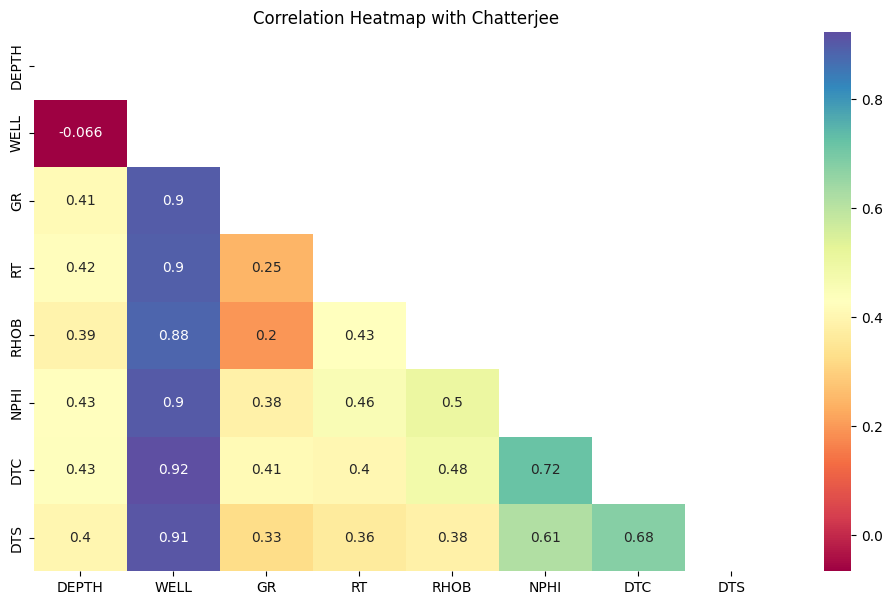

In [117]:
corr = Correlation(train)
v = corr.corr(method='chatterjee')
corr.plot_heatmap('Correlation Heatmap with Chatterjee', cmap='Spectral')

### Value trimming

In [118]:
wells = pd.concat((train, test), axis='index').reset_index(drop=True)

wells['GR'] = np.where(wells['GR'] <= 200., wells['GR'], 200.)
wells['RT'] = np.where(wells['RT'] <= 2000., wells['RT'], 2000.)
# wells['NPHI'] = np.where(wells['NPHI'] <= 0.5, wells['NPHI'], 0.5)

wells['RT'] = np.log10(wells['RT'])

In [119]:
wells.describe()

,DEPTH,GR,RT,RHOB,NPHI,DTC,DTS
count,47041.000000,47041.000000,47041.000000,47041.000000,47041.000000,47041.000000,47041.000000
mean,3299.561946,33.066103,0.447363,2.485706,0.156258,75.819147,140.936201
std,454.276121,36.199045,0.440550,0.138893,0.089311,13.159754,35.011052
min,2582.900000,0.838000,-1.148742,1.334100,0.000000,48.928000,74.386700
25%,2949.900000,9.299000,0.250956,2.444300,0.090000,66.409000,120.008400
50%,3250.600000,21.780000,0.472171,2.529000,0.135000,71.985000,131.501500
75%,3547.400000,42.418300,0.716829,2.581000,0.202000,83.907300,146.356000
max,4512.900000,200.000000,3.301030,3.201300,0.704000,136.253000,388.839000


# Normalisation and Outlier Removal

In [120]:
features = ['GR', 'RT', 'RHOB', 'NPHI'] # only feature column names
target = ['DTC', 'DTS'] # only target column names
feature_target = np.append(features, target)

# normalize using power transform Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer
ct = ColumnTransformer([('transform', scaler, features)], remainder='passthrough')

# fit and transform
new_wells = ct.fit_transform(wells)

#convert to dataframe
wells_norm = pd.DataFrame(new_wells, columns=['GR', 'RT', 'RHOB', 'NPHI', 'DEPTH', 'WELL', 'DTC', 'DTS'])

#convert into correct type
x = wells_norm[features].astype(float)
y = wells_norm['WELL'].astype(str)
z = wells_norm['DEPTH'].astype(float)

#joining data together
wells_norm = pd.concat([z, y, x], axis=1)
wells_norm['DTC'] = wells.DTC
wells_norm['DTS'] = wells.DTS

In [121]:
wells_norm.describe()

,DEPTH,GR,RT,RHOB,NPHI,DTC,DTS
count,47041.000000,4.704100e+04,4.704100e+04,4.704100e+04,4.704100e+04,47041.000000,47041.000000
mean,3299.561946,-1.450056e-16,-9.183690e-17,4.591845e-16,1.160045e-16,75.819147,140.936201
std,454.276121,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,13.159754,35.011052
min,2582.900000,-2.870742e+00,-3.581629e+00,-3.076944e+00,-3.012233e+00,48.928000,74.386700
25%,2949.900000,-7.940247e-01,-4.487941e-01,-4.796181e-01,-7.698021e-01,66.409000,120.008400
50%,3250.600000,7.637847e-02,5.308676e-02,1.943472e-01,-3.598334e-02,71.985000,131.501500
75%,3547.400000,7.466026e-01,6.100171e-01,6.796739e-01,7.575927e-01,83.907300,146.356000
max,4512.900000,2.215411e+00,6.568371e+00,1.367398e+01,2.561313e+00,136.253000,388.839000


# Split into train and test

In [122]:
train_ = wells_norm[:train.shape[0]]
test_ = wells_norm[train.shape[0]:]

train_x_ = train_[train_.columns[2:6]]
train_y_ = train_[['DTC', 'DTS']]

train_x, val_x, train_y, val_y = train_test_split(train_x_, train_y_, shuffle=True,
                                                  test_size=0.3, random_state=2024)

test_x = test_[test_.columns[2:6]]
test_y = test_[['DTC', 'DTS']]

In [123]:
train_x.shape, train_y.shape

((16877, 4), (16877, 2))

In [124]:
test_well2_x = test_x[:well2.shape[0]]
test_well2_y = test_y[:well2.shape[0]]

test_well5_x = test_x[well2.shape[0]:]
test_well5_y = test_y[well2.shape[0]:]

In [125]:
train_well1_x = train_x_[:well1.shape[0]]
train_well1_y = train_y_[:well1.shape[0]]

train_well3_x = train_x_[well1.shape[0]:(well1.shape[0]+well3.shape[0])]
train_well3_y = train_y_[well1.shape[0]:(well1.shape[0]+well3.shape[0])]

train_well4_x = train_x_[(well1.shape[0]+well3.shape[0]):]
train_well4_y = train_y_[(well1.shape[0]+well3.shape[0]):]

In [126]:
train_well3_x.shape, well3.shape

((10214, 4), (10214, 8))

In [127]:
# def interpolate_features_and_labels(features, labels, num_interpolations=3):
#     interpolated_features = []
#     interpolated_labels = []
#     for i in range(features.shape[0] - 1):
#         for _ in range(num_interpolations):
#             alpha = np.random.uniform(0, 1)
#             interpolated_feature = alpha * features[i] + (1 - alpha) * features[i + 1]
#             interpolated_label = alpha * labels[i] + (1 - alpha) * labels[i + 1]
#             interpolated_features.append(interpolated_feature)
#             interpolated_labels.append(interpolated_label)
#     return np.vstack(interpolated_features), np.vstack(interpolated_labels)

In [128]:
# def add_gaussian_noise(data, mean=0, std=0.1):
#     noise = np.random.normal(mean, std, data.shape)
#     augmented_data = data + noise
#     return augmented_data



In [129]:
# train_x = add_gaussian_noise(train_x)
# train_x.shape

In [130]:
train_x

,GR,RT,RHOB,NPHI
22981,0.866213,0.159635,0.590458,-0.628149
3954,-1.815982,0.037661,0.142041,-0.435980
17595,0.928283,0.363841,0.384230,0.278366
13714,-1.525377,0.831879,0.848351,-1.315359
18428,1.025838,-0.116621,1.250375,0.340907
...,...,...,...,...
14875,-0.686799,-0.108365,0.174210,-0.282703
2688,-2.227645,-0.110403,-0.156753,-0.386644
19040,2.215411,-0.730520,-0.698154,2.158677
19962,0.967244,0.503204,1.287522,-0.959477


# Convolutional Neural Network Architecture

In [131]:
# from torch.utils.data import Dataset
# from torch.utils.data.sampler import SubsetRandomSampler

# class LogDataset(Dataset):
#     def __init__(self, x, y):
#         self.x = torch.from_numpy(x.values)
#         self.y = torch.from_numpy(y.values)

#     def __len__(self):
#         return len(self.x)

#     def __getitem__(self, idx):
#         x = self.x[idx]
#         y = self.y[idx]

#         return x, y

# def dloader(x, y, bs=64, split='train', val_size=0.3):

#     tensor = LogDataset(x, y)

#     # obtain training indices that will be used for validation
#     num_train = len(tensor)
#     indices = list(range(num_train))
#     np.random.shuffle(indices)
#     split = int(np.floor(val_size * num_train))
#     train_idx, val_idx = indices[split:], indices[:split]

#     # define samplers for obtaining training and validation batches

#     if split=='train':
#         loader = DataLoader(tensor, bs,
#                             sampler=SubsetRandomSampler(train_idx),
#                             num_workers=0)
#         return loader

#     elif split=='val':
#         loader = DataLoader(tensor, bs,
#                             sampler=SubsetRandomSampler(val_idx),
#                             num_workers=0)
#         return loader

# def dataloader(x, y, bs=64, split='train', val_size=0.3):

#     inputs = torch.from_numpy(x.values).cuda().float()
#     outputs = torch.from_numpy(y.values).cuda().float()
#     tensor = TensorDataset(inputs, outputs)

#     # obtain training indices that will be used for validation
#     num_train = len(tensor)
#     indices = list(range(num_train))
#     np.random.shuffle(indices)
#     split = int(np.floor(val_size * num_train))
#     train_idx, val_idx = indices[split:], indices[:split]
#     # define samplers for obtaining training and validation batches

#     train_sampler = SubsetRandomSampler(train_idx)
#     valid_sampler = SubsetRandomSampler(val_idx)

#     if split=='train':
#         loader = DataLoader(tensor, bs,
#                             sampler=train_sampler,
#                             num_workers=1)
#         return loader

#     elif split=='val':
#         loader = DataLoader(tensor, bs,
#                             sampler=valid_sampler,
#                             num_workers=1)
#         return loader

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dataloader(x, y, bs=64):
    inputs = torch.from_numpy(x.values).to(device).float()
    outputs = torch.from_numpy(y.values).to(device).float()
    tensor = TensorDataset(inputs, outputs)
    loader = DataLoader(tensor, bs, shuffle=True, drop_last=True)

    return loader

In [133]:
trainloader = dataloader(train_x, train_y)
valloader = dataloader(val_x, val_y)
testloader = dataloader(test_x, test_y)

In [134]:
class Log1DNetv2(nn.Module):

    def __init__(self, n_features:int=4, batch_size:int=64, n_outputs:int=2):
        super(Log1DNetv2, self).__init__()
        self.features = n_features
        self.bs = batch_size
        self.outputs = n_outputs

        self.conv1 = nn.Sequential(
            nn.Conv1d(n_features, batch_size, kernel_size=1),
            nn.BatchNorm1d(batch_size),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.AvgPool1d(1),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(batch_size, batch_size*2, kernel_size=1),
            nn.BatchNorm1d(batch_size*2),
            nn.ReLU(),
            # nn.Dropout(0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(batch_size*2, batch_size*3, kernel_size=1),
            nn.BatchNorm1d(batch_size*3),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(batch_size*3, batch_size, kernel_size=1),
            nn.BatchNorm1d(batch_size),
            nn.ReLU(),
        )
        self.flat = nn.Flatten()
        self.layer = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.output = nn.Sequential(
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = x.reshape(self.bs, self.features, 1)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flat(out)
        out = self.layer(out)
        out = self.output(out)

        return out

class Log1DNetv3(nn.Module):

    def __init__(self, n_features:int=4, batch_size:int=64, n_outputs:int=2):
        super(Log1DNetv3, self).__init__()
        self.features = n_features
        self.bs = batch_size
        self.outputs = n_outputs

        self.conv1 = nn.Sequential(
            nn.Conv1d(n_features, batch_size, kernel_size=1),
            nn.BatchNorm1d(batch_size),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.AvgPool1d(1),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(batch_size, batch_size*2, kernel_size=1),
            nn.BatchNorm1d(batch_size*2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.AvgPool1d(1),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(batch_size*2, batch_size*4, kernel_size=1),
            nn.BatchNorm1d(batch_size*4),
            nn.Dropout(0.5),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(batch_size*4, batch_size, kernel_size=1),
            nn.BatchNorm1d(batch_size),
            nn.ReLU(),
        )
        self.flat = nn.Flatten()
        self.layer = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.output = nn.Sequential(
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = x.reshape(self.bs, self.features, 1)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flat(out)
        out = self.layer(out)
        out = self.output(out)

        return out

In [135]:
def criterion(model:Log1DNetv2, dataloader:DataLoader, train:bool=False, optimizer:Adam=None):
    dtc_loss, dts_loss = MSELoss(), MSELoss()
    dtc_score, dts_score = R2Score(), R2Score()#.to('cuda:0')

    dtc_avg_loss = 0; dtc_avg_score = 0
    dts_avg_loss = 0; dts_avg_score = 0

    count = 0

    for input, output in iter(dataloader):
        predictions = model(input)
        #dtc
        dtc_loss_ = torch.sqrt(dtc_loss(predictions[:, 0], output[:, 0]))
        dtc_score.update([predictions[:, 0], output[:, 0]])
        dtc_score_ = dtc_score.compute()

        #dts
        dts_loss_ = torch.sqrt(dts_loss(predictions[:, 1], output[:, 1]))
        dts_score.update([predictions[:, 1], output[:, 1]])
        dts_score_ = dts_score.compute()

        if train:
            optimizer.zero_grad()
            dtc_loss_.backward(retain_graph=True)
            dts_loss_.backward()
            optimizer.step()

        dtc_avg_loss += dtc_loss_.item()
        dtc_avg_score += dtc_score_

        dts_avg_loss += dts_loss_.item()
        dts_avg_score += dts_score_

        count += 1

    return dtc_avg_loss/count, dtc_avg_score/count, dts_avg_loss/count, dts_avg_score/count



In [136]:
EPOCHS = 200
BATCH_SIZE = 64

In [137]:
def main(model:Log1DNetv2, trainloader:DataLoader, testloader:DataLoader):
    train_dtc_loss, train_dtc_score, train_dts_loss, train_dts_score = list(), list(), list(), list()
    val_dtc_loss, val_dtc_score, val_dts_loss, val_dts_score = list(), list(), list(), list()

    optimizer = Adam(model.parameters(), lr=1e-1)

    best_val_loss = Inf

    for epoch in tqdm(range(EPOCHS)):
        tn_dtc_avg_loss, tn_dtc_avg_score, tn_dts_avg_loss, tn_dts_avg_score = criterion(model, trainloader, train=True, optimizer=optimizer)
        tt_dtc_avg_loss, tt_dtc_avg_score, tt_dts_avg_loss, tt_dts_avg_score = criterion(model, testloader, train=False, optimizer=optimizer)
        #train
        train_dtc_loss.append(tn_dtc_avg_loss); train_dtc_score.append(tn_dtc_avg_score)
        train_dts_loss.append(tn_dts_avg_loss); train_dts_score.append(tn_dts_avg_score)
        #val
        val_dtc_loss.append(tt_dtc_avg_loss); val_dtc_score.append(tt_dtc_avg_score)
        val_dts_loss.append(tt_dts_avg_loss); val_dts_score.append(tt_dts_avg_score)

        if (tt_dtc_avg_loss+tt_dts_avg_loss) < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            print('Model Saved')

            best_val_loss = tt_dtc_avg_loss+tt_dts_avg_loss

        print(f'Epoch {epoch+1} Train: DTC Loss={tn_dtc_avg_loss:.4f} | DTC Score={tn_dtc_avg_score:.4f} | DTS Loss={tn_dts_avg_loss:.4f} | DTS Score={tn_dts_avg_score:.4f}')
        print(f'Epoch {epoch+1} Val: DTC Loss={tt_dtc_avg_loss:.4f} | DTC Score={tt_dtc_avg_score:.4f} | DTS Loss={tt_dts_avg_loss:.4f} | DTS Score={tt_dts_avg_score:.4f}')
        print()


    return train_dtc_loss, train_dtc_score, train_dts_loss, train_dts_score, val_dtc_loss, val_dtc_score, val_dts_loss, val_dts_score

model = Log1DNetv3()

print(model.to(device))

random_seed = 9898
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

train_dtc_loss, train_dtc_score, train_dts_loss, train_dts_score,\
 val_dtc_loss, val_dtc_score, val_dts_loss, val_dts_score = main(model, trainloader, valloader)

Log1DNetv3(
  (conv1): Sequential(
    (0): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  )
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (flat): Flatten(start_dim=1

  0%|          | 0/200 [00:00<?, ?it/s]

Model Saved
Epoch 1 Train: DTC Loss=10.0636 | DTC Score=-1.8273 | DTS Loss=24.0621 | DTS Score=-0.4818
Epoch 1 Val: DTC Loss=8.0755 | DTC Score=0.6197 | DTS Loss=18.2290 | DTS Score=0.6973

Model Saved
Epoch 2 Train: DTC Loss=7.6869 | DTC Score=0.4688 | DTS Loss=20.2180 | DTS Score=0.6072
Epoch 2 Val: DTC Loss=4.9446 | DTC Score=0.8472 | DTS Loss=18.1681 | DTS Score=0.7229

Epoch 3 Train: DTC Loss=6.5901 | DTC Score=0.7278 | DTS Loss=19.0434 | DTS Score=0.6857
Epoch 3 Val: DTC Loss=7.5563 | DTC Score=0.6418 | DTS Loss=17.0996 | DTS Score=0.7481

Epoch 4 Train: DTC Loss=6.2778 | DTC Score=0.7443 | DTS Loss=18.3446 | DTS Score=0.7118
Epoch 4 Val: DTC Loss=4.8029 | DTC Score=0.8663 | DTS Loss=18.6681 | DTS Score=0.7104

Model Saved
Epoch 5 Train: DTC Loss=6.1373 | DTC Score=0.7587 | DTS Loss=18.1711 | DTS Score=0.7197
Epoch 5 Val: DTC Loss=4.9160 | DTC Score=0.8429 | DTS Loss=17.3478 | DTS Score=0.7245

Epoch 6 Train: DTC Loss=5.9670 | DTC Score=0.7680 | DTS Loss=17.9015 | DTS Score=0.733

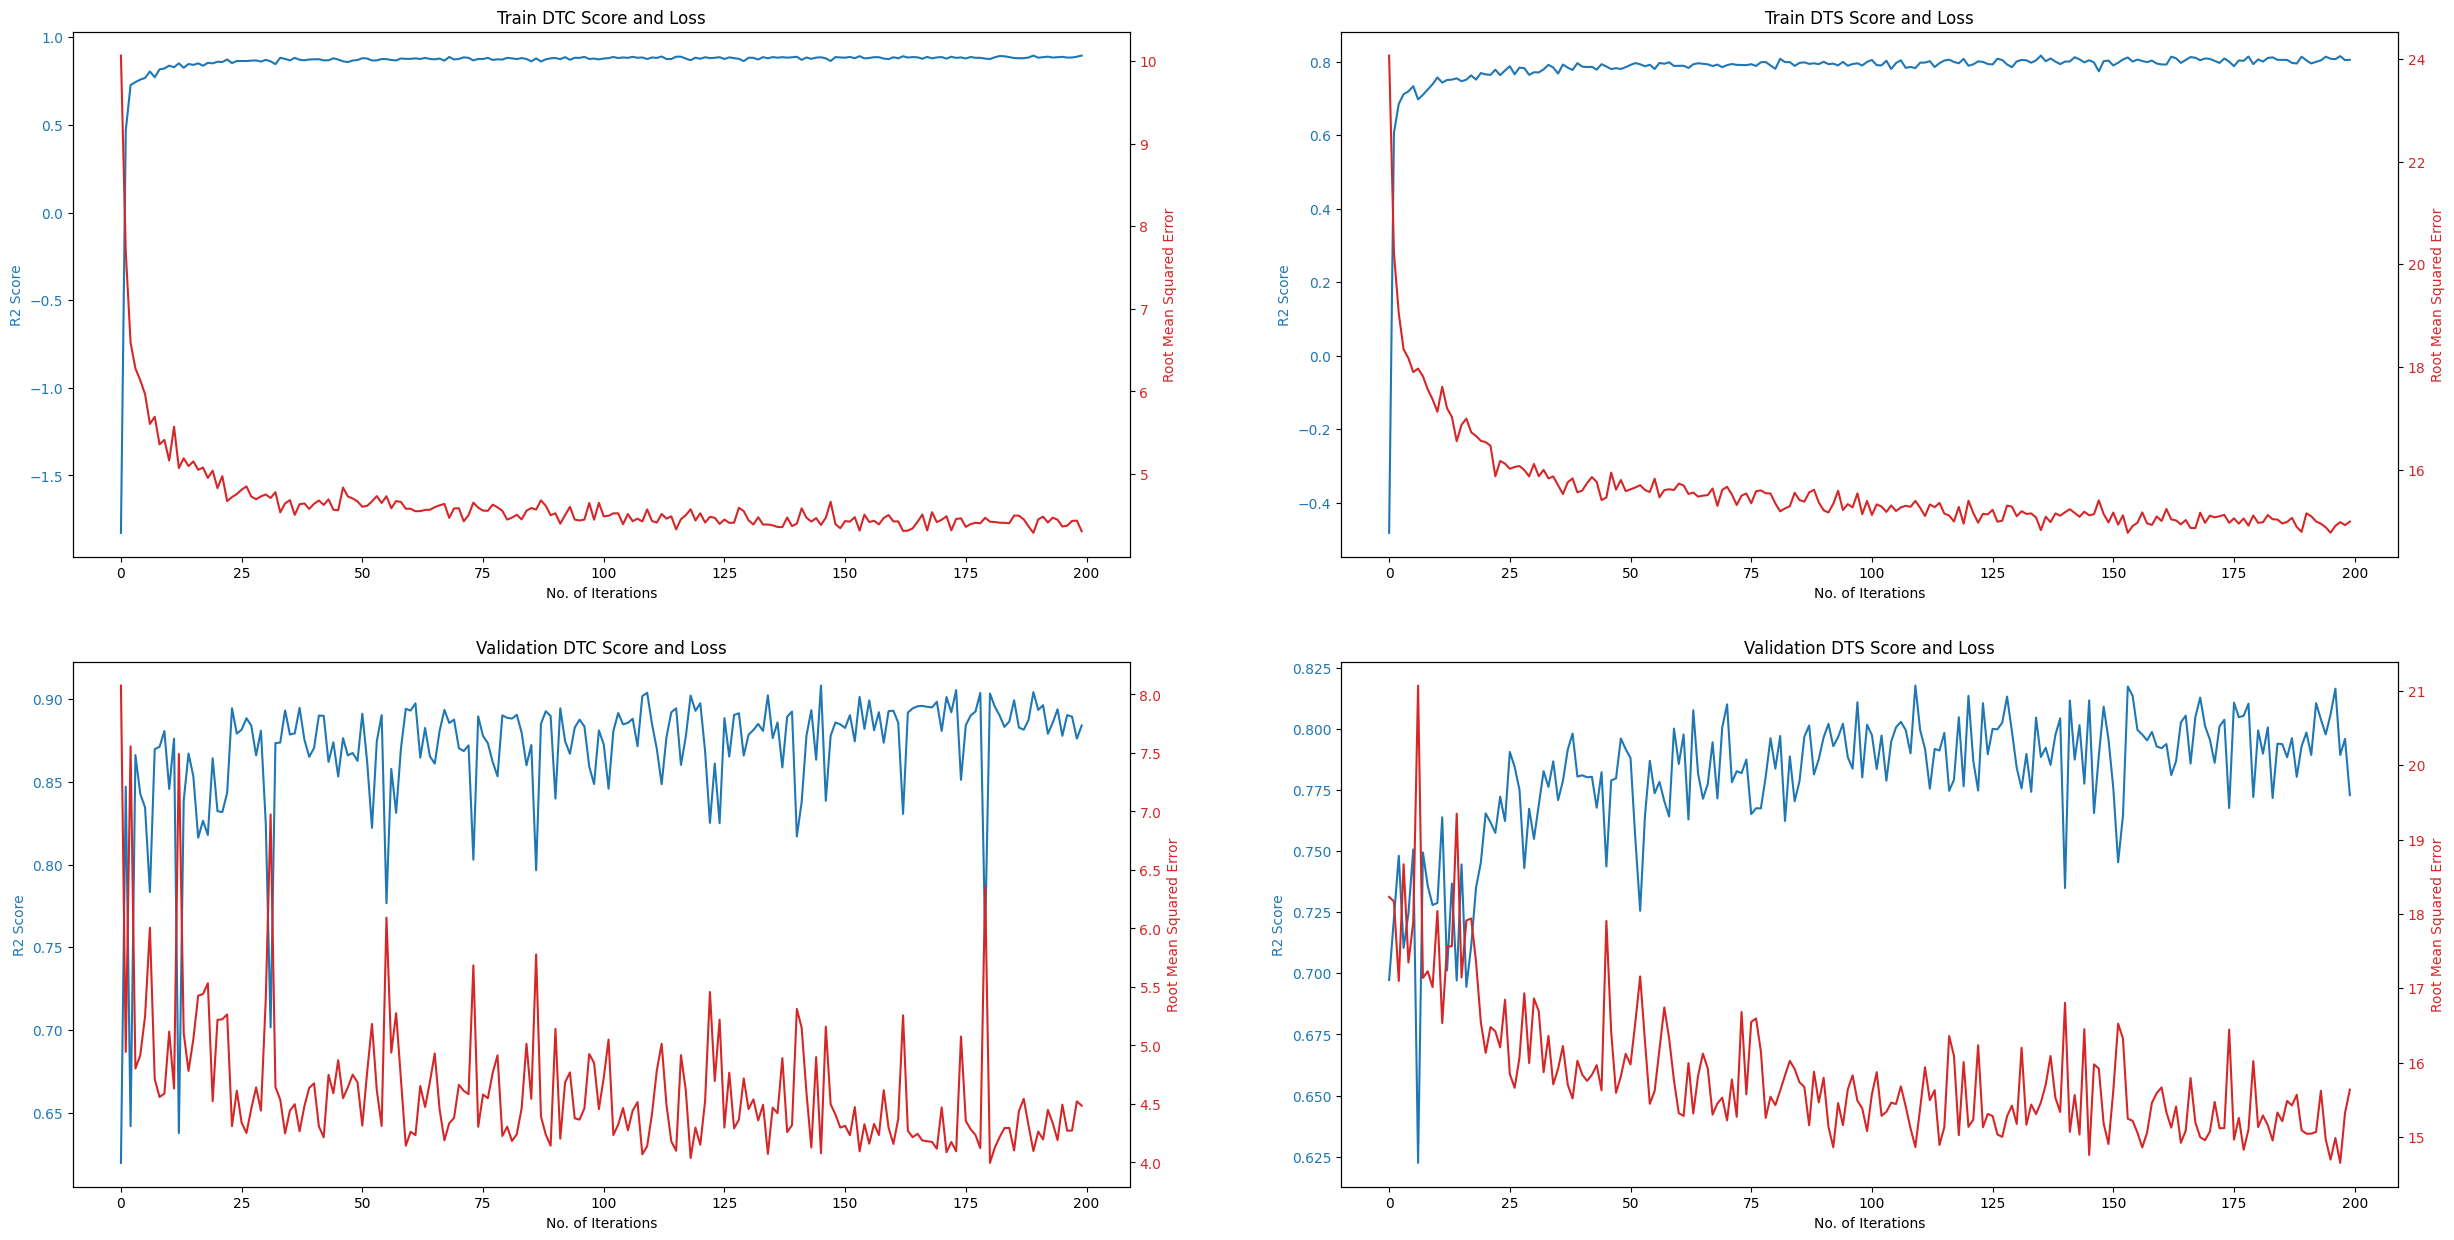

In [138]:
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(30, 15))
epochs_range = range(len(train_dtc_loss))

# Plotting for subplot 1
axs[0, 0].plot(epochs_range, train_dtc_score, color='tab:blue')
axs[0, 0].set_ylabel('R2 Score', color='tab:blue')
axs[0, 0].tick_params(axis='y', labelcolor='tab:blue')
axs[0, 0].set_xlabel('No. of Iterations')

axs2_1 = axs[0, 0].twinx()
axs2_1.plot(epochs_range, train_dtc_loss, color='tab:red')
axs2_1.set_ylabel('Root Mean Squared Error', color='tab:red')
axs2_1.tick_params(axis='y', labelcolor='tab:red')
axs2_1.set_xlabel('No of iterations')
axs[0, 0].set_title('Train DTC Score and Loss')

# Plotting for subplot 2
axs[0, 1].plot(epochs_range, train_dts_score, color='tab:blue',)
axs[0, 1].set_ylabel('R2 Score', color='tab:blue')
axs[0, 1].tick_params(axis='y', labelcolor='tab:blue')
axs[0, 1].set_xlabel('No. of Iterations')

axs2_2 = axs[0, 1].twinx()
axs2_2.plot(epochs_range, train_dts_loss, color='tab:red')
axs2_2.set_ylabel('Root Mean Squared Error', color='tab:red')
axs2_2.tick_params(axis='y', labelcolor='tab:red')
axs2_2.set_xlabel('No of iterations')
axs[0, 1].set_title('Train DTS Score and Loss')

# Plotting for subplot 3
axs[1, 0].plot(epochs_range, val_dtc_score, color='tab:blue')
axs[1, 0].set_ylabel('R2 Score', color='tab:blue')
axs[1, 0].tick_params(axis='y', labelcolor='tab:blue')
axs[1, 0].set_xlabel('No. of Iterations')

axs2_3 = axs[1, 0].twinx()
axs2_3.plot(epochs_range, val_dtc_loss, color='tab:red')
axs2_3.set_ylabel('Root Mean Squared Error', color='tab:red')
axs2_3.tick_params(axis='y', labelcolor='tab:red')
axs2_3.set_xlabel('No of iterations')
axs[1, 0].set_title('Validation DTC Score and Loss')

# Plotting for subplot 4
axs[1, 1].plot(epochs_range, val_dts_score, color='tab:blue')
axs[1, 1].set_ylabel('R2 Score', color='tab:blue')
axs[1, 1].tick_params(axis='y', labelcolor='tab:blue')
axs[1, 1].set_xlabel('No. of Iterations')

axs2_4 = axs[1, 1].twinx()
axs2_4.plot(epochs_range, val_dts_loss, color='tab:red')
axs2_4.set_ylabel('Root Mean Squared Error', color='tab:red')
axs2_4.tick_params(axis='y', labelcolor='tab:red')
axs2_4.set_xlabel('No of iterations')
axs[1, 1].set_title('Validation DTS Score and Loss')

plt.show()

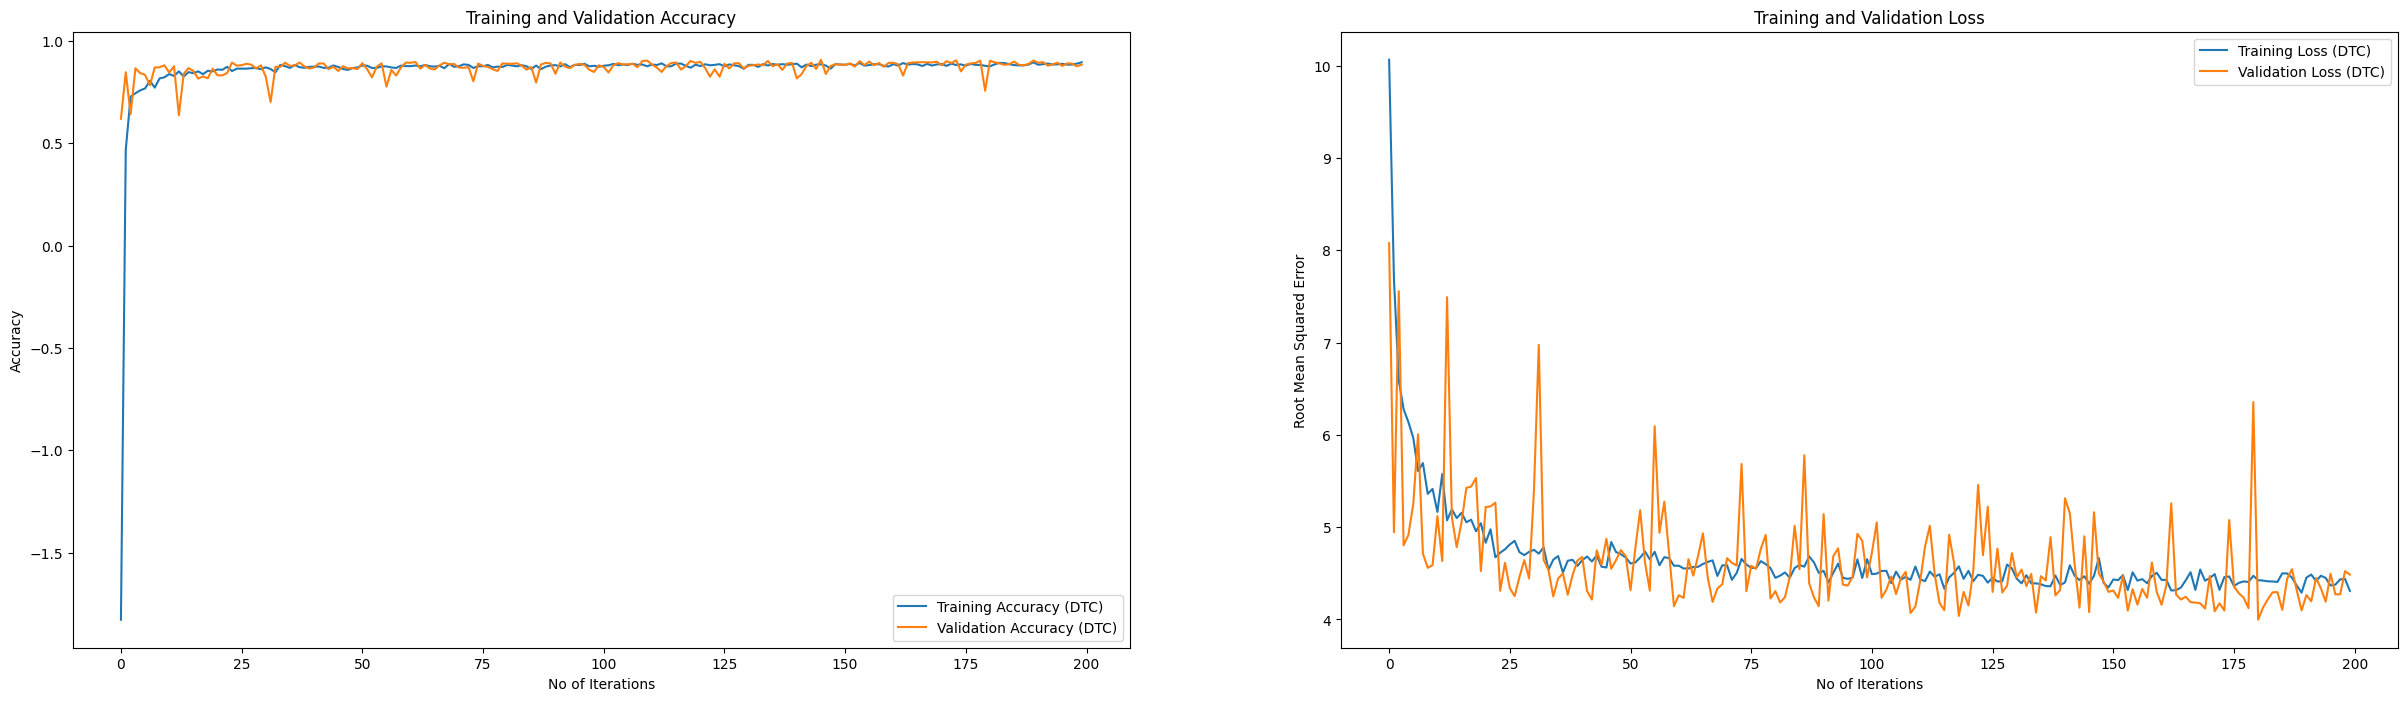

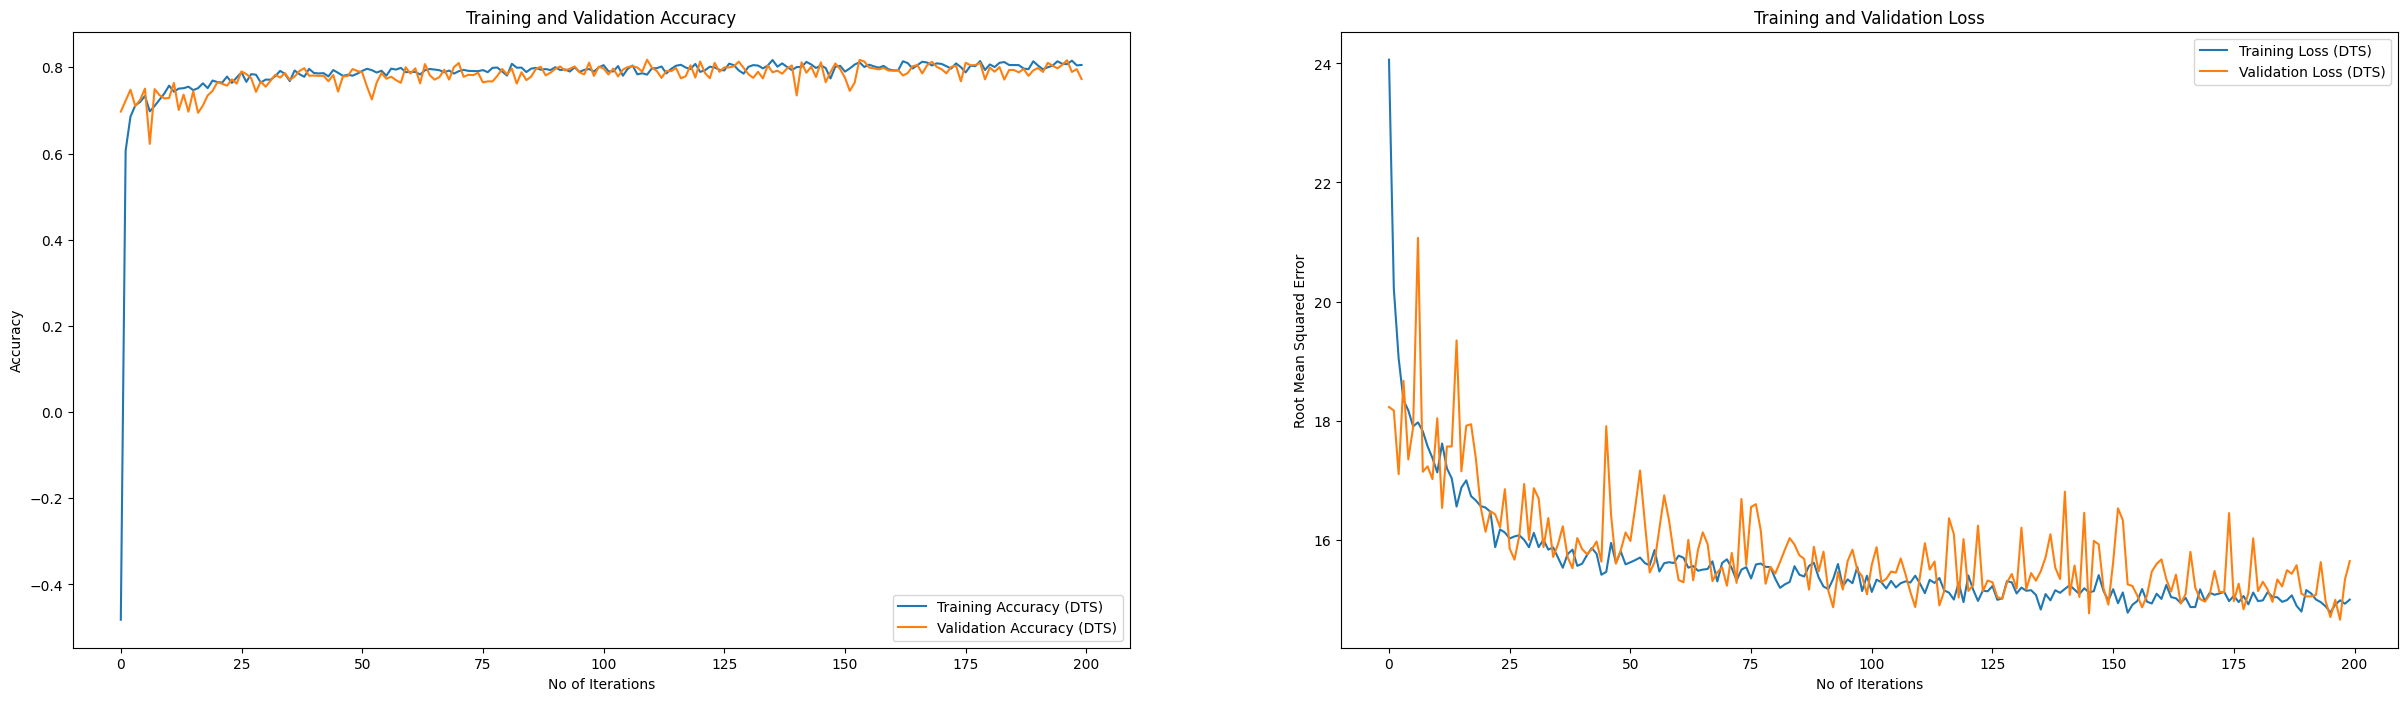

In [139]:
epochs_range = range(len(train_dtc_loss))

plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_dtc_score, label='Training Accuracy (DTC)')
plt.plot(epochs_range, val_dtc_score, label='Validation Accuracy (DTC)')
plt.legend(loc='lower right')
plt.xlabel('No of Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_dtc_loss, label='Training Loss (DTC)')
plt.plot(epochs_range, val_dtc_loss, label='Validation Loss (DTC)')
plt.legend(loc='upper right')
plt.xlabel('No of Iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Validation Loss')

plt.show()

plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_dts_score, label='Training Accuracy (DTS)')
plt.plot(epochs_range, val_dts_score, label='Validation Accuracy (DTS)')
plt.legend(loc='lower right')
plt.xlabel('No of Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_dts_loss, label='Training Loss (DTS)')
plt.plot(epochs_range, val_dts_loss, label='Validation Loss (DTS)')
plt.legend(loc='upper right')
plt.xlabel('No of Iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Validation Loss')

plt.show()


In [140]:
def load_model(modelpath:str='/content/best_model.pt'):

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = Log1DNetv3().to(device)
    model.load_state_dict(torch.load(modelpath))

    return model


def predict_logs(x, y, original_df):
    model = load_model()

    inputs = torch.from_numpy(x.values).to(device).float()
    outputs = torch.from_numpy(y.values).to(device).float()

    dtcs = []; dtss = []
    model.eval()
    for i in range(inputs.shape[0]):
        with torch.inference_mode():
            pred = model(inputs[i].unsqueeze(0).repeat(64, 1, 1))
            dtc = pred[0][0]; dts = pred[0][1]
            dtcs.append(dtc.cpu().numpy()); dtss.append(dts.cpu().numpy())

    df = original_df.copy()
    df['Predicted DTC'] = np.array(dtcs).astype(float)
    df['Predicted DTS'] = np.array(dtss).astype(float)

    return df

In [141]:
def make_log_plot(logs, x1, x2, x3, x4, x5, x6, x7, x8, well_name):

    """
    DESC: Displays log plot
    args::
        logs: dataframe
        x1: GR
        x2: RT
        x3: NPHI
        x4: RHOB
        x5: CALI
        x6: DTC
        x7: DTS
        well_name: str
    Returns plots

    """

    ztop = logs['DEPTH'].min(); zbot=logs['DEPTH'].max()

    #defining plot figure
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12), sharey=True)
    ax[0].set_ylabel("DEPTH(m)")
    f.suptitle(f'Well - {well_name}', fontsize=20, y=1.02)

    #for gamma ray track
    ax[0].minorticks_on()
    ax[0].grid(which='major', linestyle='-', linewidth=1, color='darkgrey')
    ax[0].yaxis.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgrey')
    ax[0].plot(logs[x1], logs['DEPTH'], '-g')
    ax[0].set_xlim(0, 200)#logs[x1].min(), logs[x1].max())
    ax[0].set_xlabel('GR(gAPI)', fontsize=12)
    ax[0].xaxis.label.set_color('green')
    ax[0].tick_params(axis='x', colors='green')
    ax[0].spines['top'].set_edgecolor('green')
    ax[0].spines["top"].set_position(("axes", 1.02))
    ax[0].set_ylim(ztop, zbot)
    ax[0].xaxis.set_ticks_position("top")
    ax[0].xaxis.set_label_position("top")
    ax[0].invert_yaxis()


    #for resitivity log
    ax[1].minorticks_on()
    ax[1].grid(which='major', linestyle='-', linewidth=1.0, color='darkgrey')
    ax[1].grid(which='minor', linestyle='-', linewidth=0.5, color='lightgrey')
    ax[1].plot(logs[x2], logs['DEPTH'], '-r')
    ax[1].set_xlim(0.2, 2000)
    ax[1].set_xlabel('RT(ohm-m)', fontsize=12)
    ax[1].xaxis.label.set_color('red')
    ax[1].tick_params(axis='x', colors='red')
    ax[1].spines['top'].set_edgecolor('red')
    ax[1].spines["top"].set_position(("axes", 1.02))
    ax[1].set_ylim(ztop, zbot)
    ax[1].xaxis.set_ticks_position("top")
    ax[1].xaxis.set_label_position("top")
    ax[1].invert_yaxis()
    ax[1].set_xscale("log")

    #for neutron porosity
    ax[2].minorticks_on()
    ax[2].yaxis.grid(which='major', linestyle='-', linewidth=1, color='darkgrey')
    ax[2].yaxis.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgrey')
    ax[2].set_xticklabels([]);ax[2].set_xticks([])
    rhob_ = ax[2].twiny()
    rhob_.plot(logs[x3], logs['DEPTH'], '-b')
    rhob_.set_xlim(logs[x3].min(), logs[x3].max())
    rhob_.set_xlabel('NPHI(v/v)', fontsize=12)
    rhob_.xaxis.label.set_color('blue')
    rhob_.tick_params(axis='x', colors='blue')
    rhob_.spines['top'].set_edgecolor('blue')
    rhob_.spines["top"].set_position(("axes", 1.02))
    rhob_.set_ylim(ztop, zbot)
    rhob_.xaxis.set_ticks_position("top")
    rhob_.xaxis.set_label_position("top")
    rhob_.invert_yaxis()
    rhob_.invert_xaxis()

    #for bulk density
    nphi_ = ax[2].twiny()
    nphi_.grid(which='major', linestyle='-', linewidth=0.5, color='darkgrey')
    nphi_.plot(logs[x4], logs['DEPTH'], '-r')
    nphi_.set_xlim(logs[x4].min(), logs[x4].max())
    nphi_.set_xlabel('RHOB(g/cm3)', fontsize=12)
    nphi_.xaxis.label.set_color('red')
    nphi_.tick_params(axis='x', colors='red')
    nphi_.spines['top'].set_edgecolor('red')
    nphi_.spines["top"].set_position(("axes", 1.07))
    nphi_.set_ylim(ztop, zbot)
    nphi_.xaxis.set_ticks_position("top")
    nphi_.xaxis.set_label_position("top")
    nphi_.invert_yaxis()


    #for DTC
    ax[3].minorticks_on()
    ax[3].yaxis.grid(which='major', linestyle='-', linewidth=1, color='darkgrey')
    ax[3].yaxis.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgrey')
    ax[3].set_xticklabels([]);ax[3].set_xticks([])
    dtc_ = ax[3].twiny()
    dtc_.plot(logs[x5], logs['DEPTH'], '-', c='purple')
    dtc_.set_xlim(40, 240)
    dtc_.set_xlabel('True DTC(us/ft)', fontsize=12)
    dtc_.xaxis.label.set_color('purple')
    dtc_.tick_params(axis='x', colors='purple')
    dtc_.spines['top'].set_edgecolor('purple')
    dtc_.spines["top"].set_position(("axes", 1.02))
    dtc_.set_ylim(ztop, zbot)
    dtc_.xaxis.set_ticks_position("top")
    dtc_.xaxis.set_label_position("top")
    dtc_.invert_yaxis()


    #for predicted DTC
    dts_ = ax[3].twiny()
    dts_.grid(which='major', linestyle='-', linewidth=0.5, color='darkgrey')
    dts_.plot(logs[x6], logs['DEPTH'], '-', c='black')
    dts_.set_xlim(40, 240)
    dts_.set_xlabel('Predicted DTC(us/ft)', fontsize=12)
    dts_.xaxis.label.set_color('black')
    dts_.tick_params(axis='x', colors='black')
    dts_.spines['top'].set_edgecolor('black')
    dts_.spines["top"].set_position(("axes", 1.07))
    dts_.set_ylim(ztop, zbot)
    dts_.xaxis.set_ticks_position("top")
    dts_.xaxis.set_label_position("top")
    dts_.invert_yaxis()


    #for DTS
    ax[4].minorticks_on()
    ax[4].yaxis.grid(which='major', linestyle='-', linewidth=1, color='darkgrey')
    ax[4].yaxis.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgrey')
    ax[4].set_xticklabels([]);ax[4].set_xticks([])
    true = ax[4].twiny()
    true.plot(logs[x7], logs['DEPTH'], '-', c='purple')
    true.set_xlim(80, 380)
    true.set_xlabel('True DTS(us/ft)', fontsize=12)
    true.xaxis.label.set_color('purple')
    true.tick_params(axis='x', colors='purple')
    true.spines['top'].set_edgecolor('purple')
    true.spines["top"].set_position(("axes", 1.02))
    true.set_ylim(ztop, zbot)
    true.xaxis.set_ticks_position("top")
    true.xaxis.set_label_position("top")
    true.invert_yaxis()


    #for predicted DTS
    pred = ax[4].twiny()
    pred.grid(which='major', linestyle='-', linewidth=0.5, color='darkgrey')
    pred.plot(logs[x8], logs['DEPTH'], '-', c='black')
    pred.set_xlim(80, 380)
    pred.set_xlabel('Predicted DTS(us/ft)', fontsize=12)
    pred.xaxis.label.set_color('black')
    pred.tick_params(axis='x', colors='black')
    pred.spines['top'].set_edgecolor('black')
    pred.spines["top"].set_position(("axes", 1.07))
    pred.set_ylim(ztop, zbot)
    pred.xaxis.set_ticks_position("top")
    pred.xaxis.set_label_position("top")
    pred.invert_yaxis()

    plt.tight_layout(h_pad=1)
    # plt.tight_layout(h_pad=1)
    f.subplots_adjust(wspace=0.0)


    if well_name == '15_9-F-11A': f.savefig('15_9-F-11A.png')
    elif well_name == '15_9-F-11T2': f.savefig('15_9-F-11T2.png')
    elif well_name == '15_9-F-1A': f.savefig('15_9-F-1A.png')
    elif well_name == '15_9-F-1B': f.savefig('15_9-F-1B.png')
    elif well_name == '15_9-F-4': f.savefig('15_9-F-4.png')

# Well 2

In [142]:
well2_new = predict_logs(test_well2_x, test_well2_y, well2)

In [143]:
print(r2_score(well2_new['DTS'], well2_new['Predicted DTS']))
print(sqrt(mean_squared_error(well2_new['DTS'], well2_new['Predicted DTS'])))

0.8334129472678704
15.398305039430072


In [144]:
print(r2_score(well2_new['DTC'], well2_new['Predicted DTC']))
print(sqrt(mean_squared_error(well2_new['DTC'], well2_new['Predicted DTC'])))

0.9351997539965473
3.402992090841105


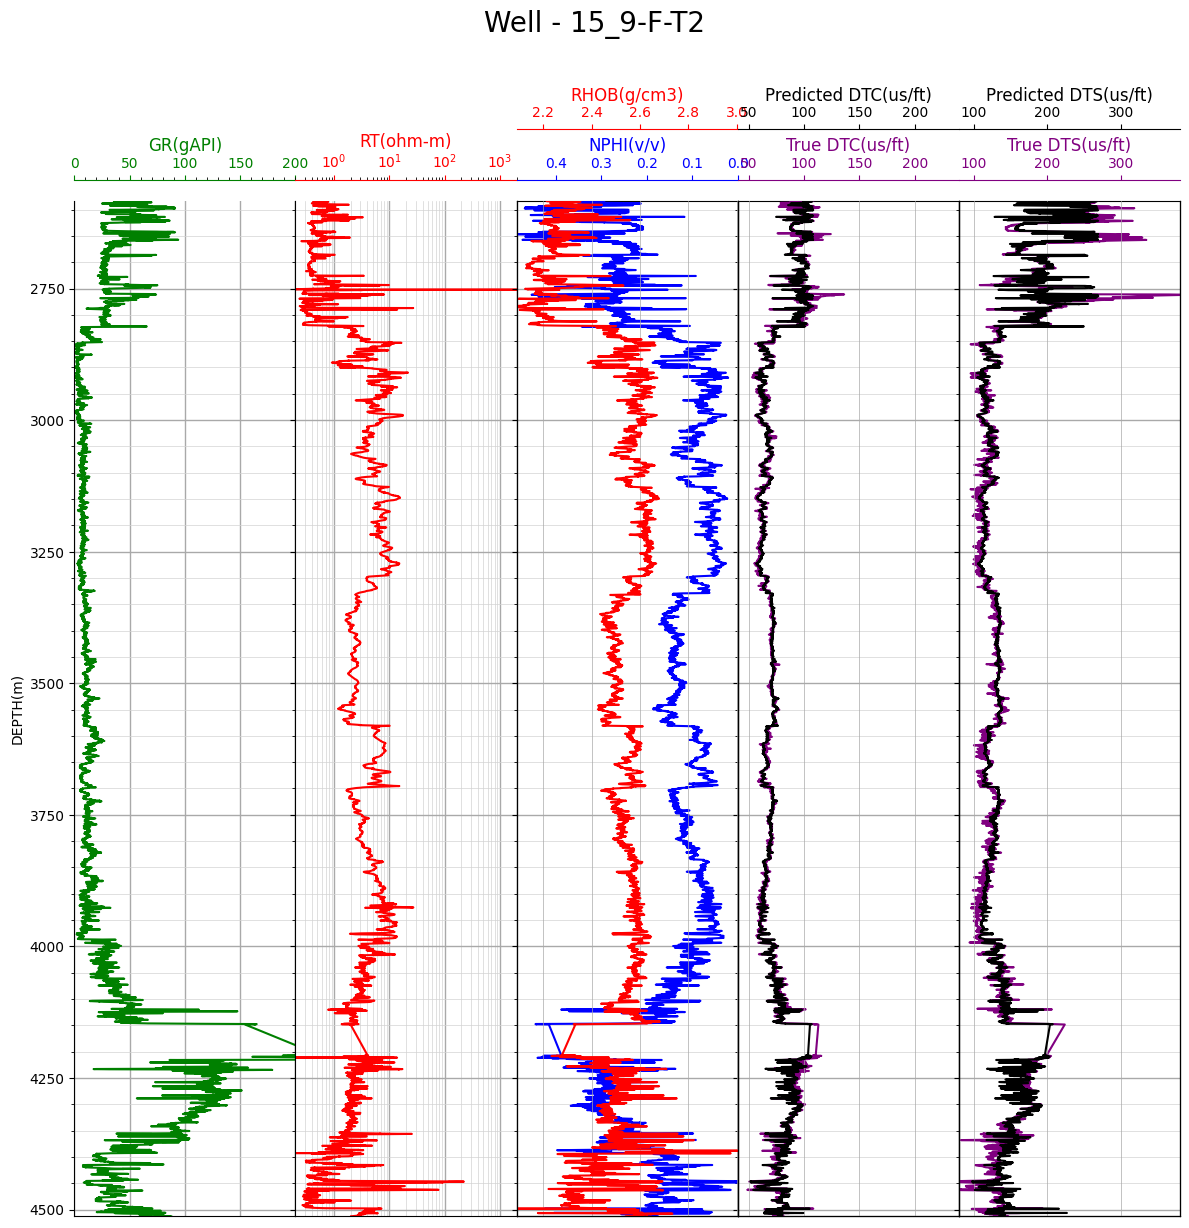

In [145]:
make_log_plot(well2_new, 'GR', 'RT', 'NPHI', 'RHOB', 'DTC', 'Predicted DTC', 'DTS', 'Predicted DTS', '15_9-F-T2')

## Well 4

In [146]:
well4_new = predict_logs(train_well4_x, train_well4_y, well4)

In [147]:
print(r2_score(well4_new['DTS'], well4_new['Predicted DTS']))
print(sqrt(mean_squared_error(well4_new['DTS'], well4_new['Predicted DTS'])))

0.7470321770897372
9.693032321788321


In [148]:
print(r2_score(well4_new['DTC'], well4_new['Predicted DTC']))
print(sqrt(mean_squared_error(well4_new['DTC'], well4_new['Predicted DTC'])))

0.8637063587813626
3.0878171712447005


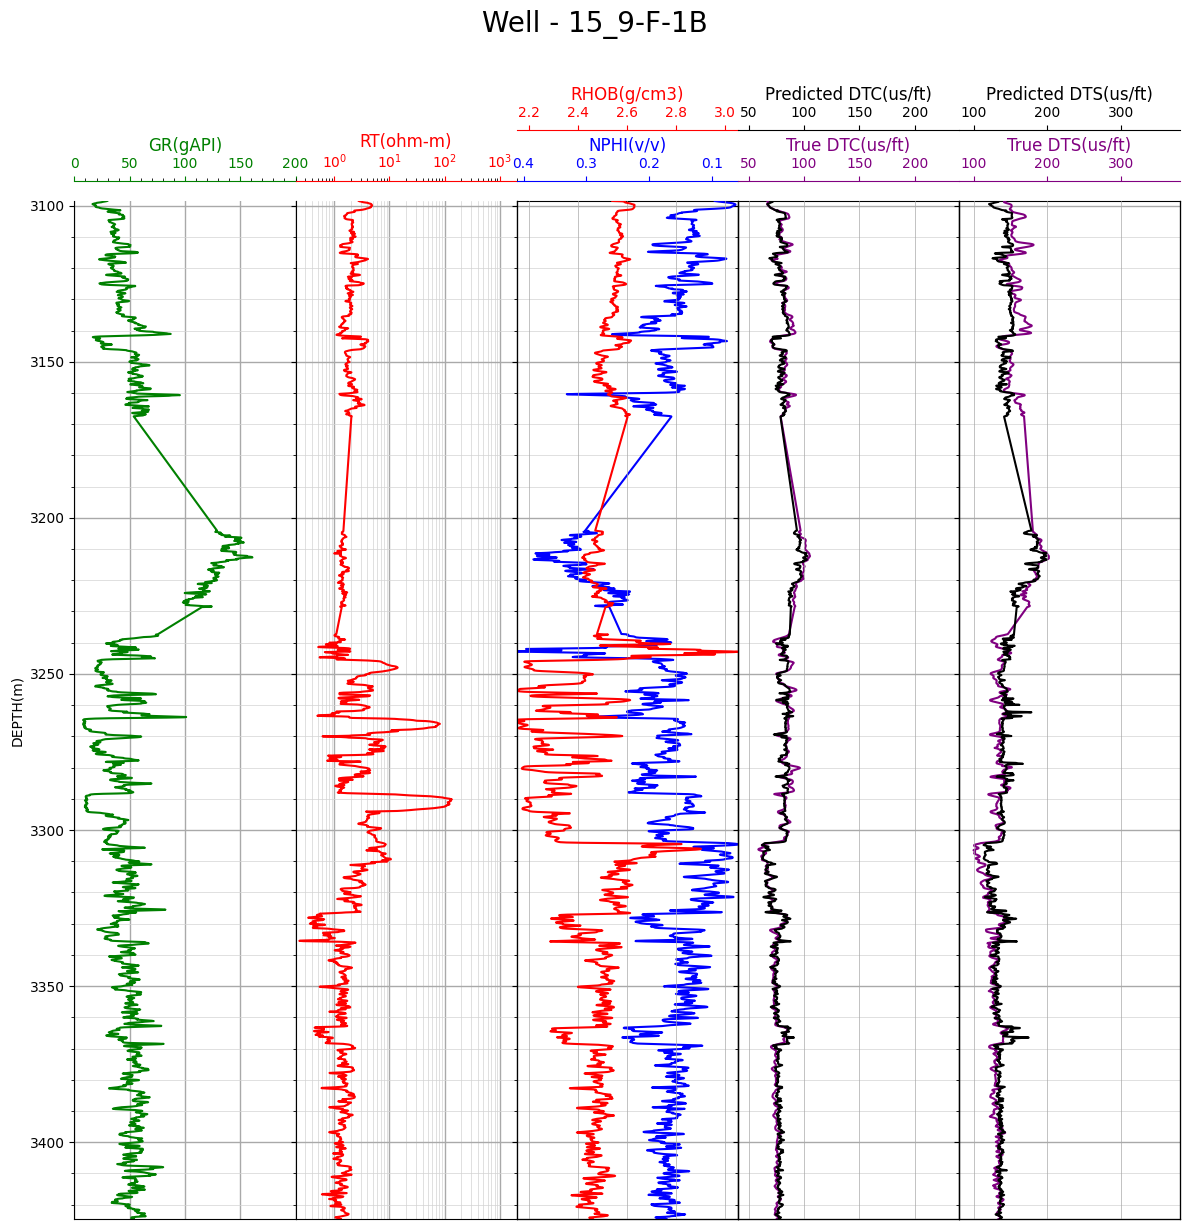

In [149]:
make_log_plot(well4_new, 'GR', 'RT', 'NPHI', 'RHOB', 'DTC', 'Predicted DTC', 'DTS', 'Predicted DTS', '15_9-F-1B')

# Well 1

In [150]:
well1_new = predict_logs(train_well1_x, train_well1_y, well1)


In [151]:
print(r2_score(well1_new['DTS'], well1_new['Predicted DTS']))
print(sqrt(mean_squared_error(well1_new['DTS'], well1_new['Predicted DTS'])))

0.8532249606844572
17.000698018873663


In [152]:
print(r2_score(well1_new['DTC'], well1_new['Predicted DTC']))
print(sqrt(mean_squared_error(well1_new['DTC'], well1_new['Predicted DTC'])))

0.9282228009436392
3.8786517534290934


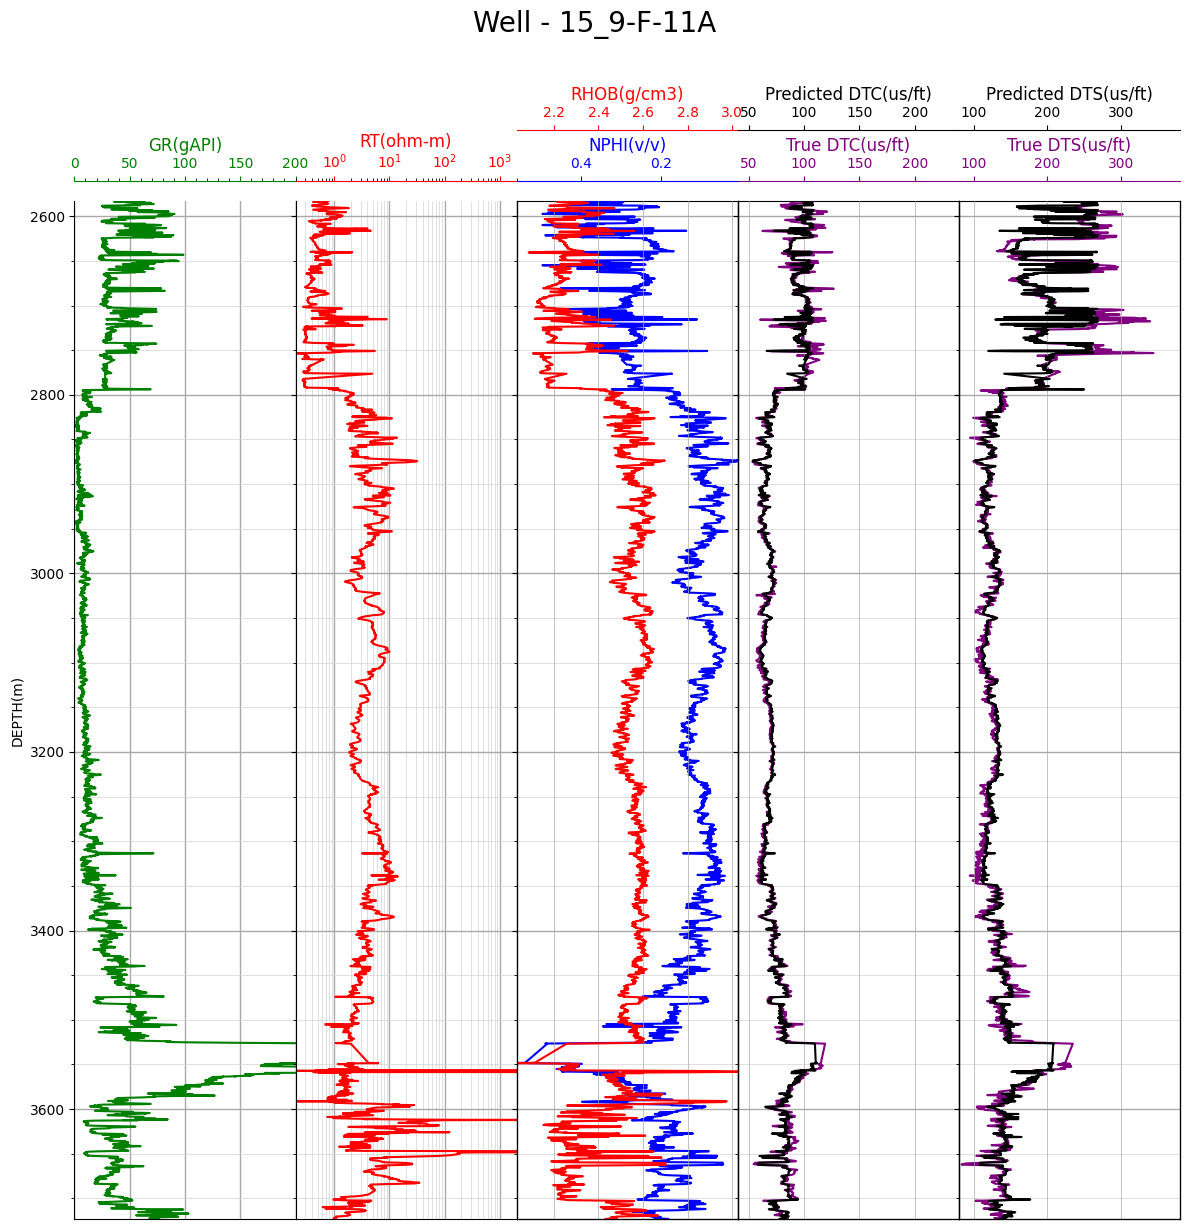

In [153]:
make_log_plot(well1_new, 'GR', 'RT', 'NPHI', 'RHOB', 'DTC', 'Predicted DTC', 'DTS', 'Predicted DTS', '15_9-F-11A')

# Well 3

In [154]:
well3_new = predict_logs(train_well3_x, train_well3_y, well3)


In [155]:

print(r2_score(well3_new['DTS'], well3_new['Predicted DTS']))
print(sqrt(mean_squared_error(well3_new['DTS'], well3_new['Predicted DTS'])))

print(r2_score(well3_new['DTC'], well3_new['Predicted DTC']))
print(sqrt(mean_squared_error(well3_new['DTC'], well3_new['Predicted DTC'])))

0.7955481763002384
11.638318124335031
0.9360583962596309
3.2417186671717935


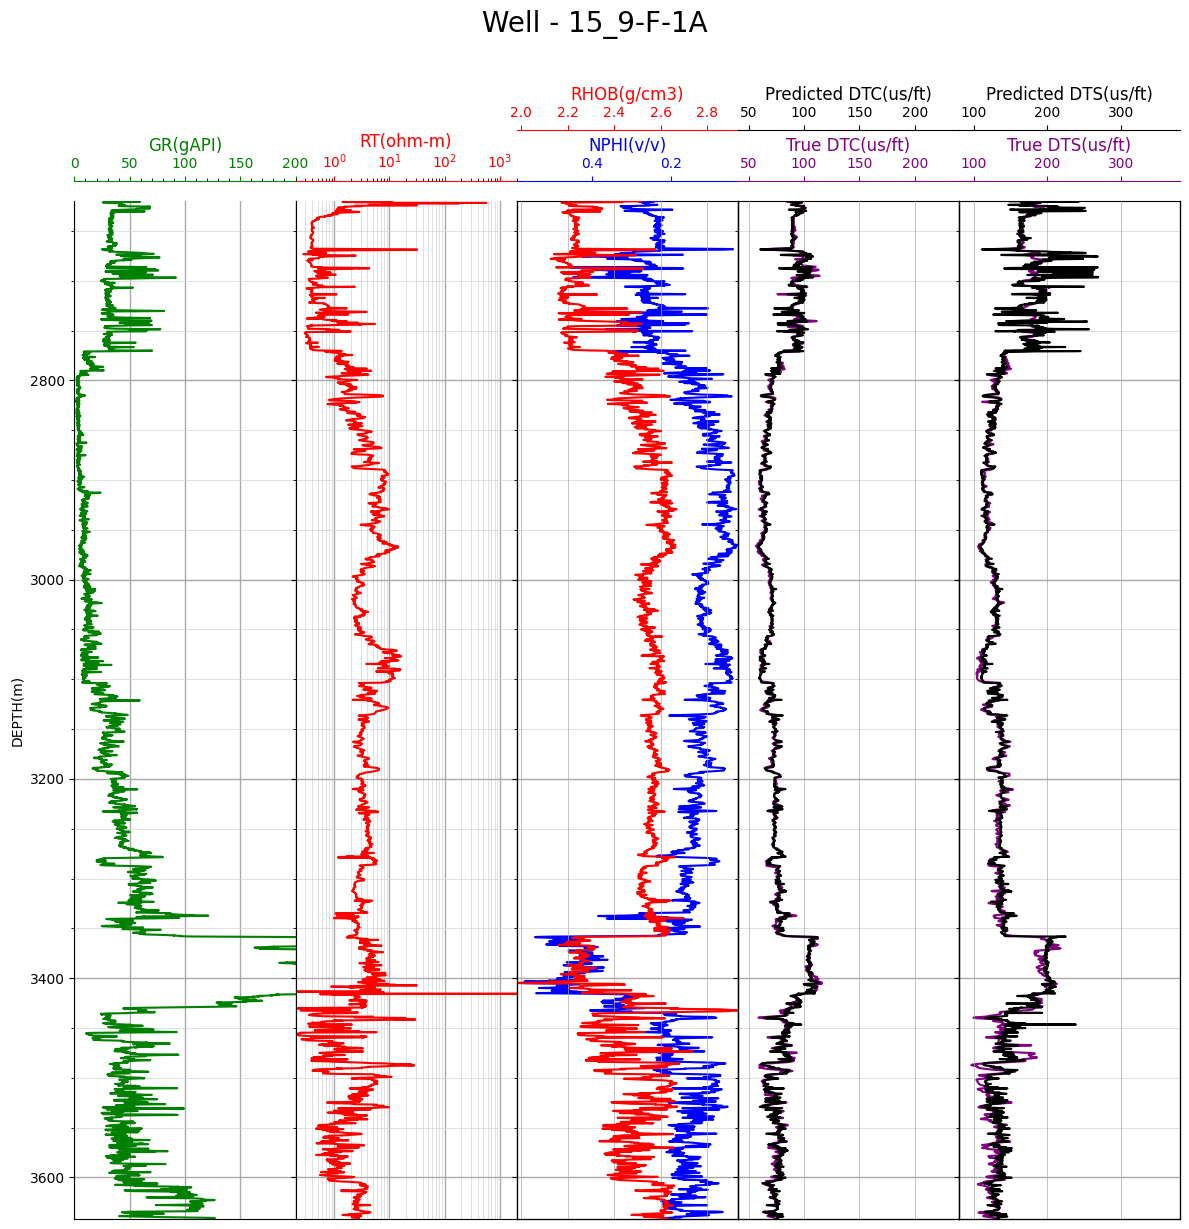

In [156]:
make_log_plot(well3_new, 'GR', 'RT', 'NPHI', 'RHOB', 'DTC', 'Predicted DTC', 'DTS', 'Predicted DTS', '15_9-F-1A')

# Well 5

In [157]:
well5_new = predict_logs(test_well5_x, test_well5_y, well5)

In [158]:
print(r2_score(well5_new['DTS'], well5_new['Predicted DTS']))
print(sqrt(mean_squared_error(well5_new['DTS'], well5_new['Predicted DTS'])))

print(r2_score(well5_new['DTC'], well5_new['Predicted DTC']))
print(sqrt(mean_squared_error(well5_new['DTC'], well5_new['Predicted DTC'])))

0.5167896854901421
10.915410571114826
0.8417523420517274
4.307084396867788


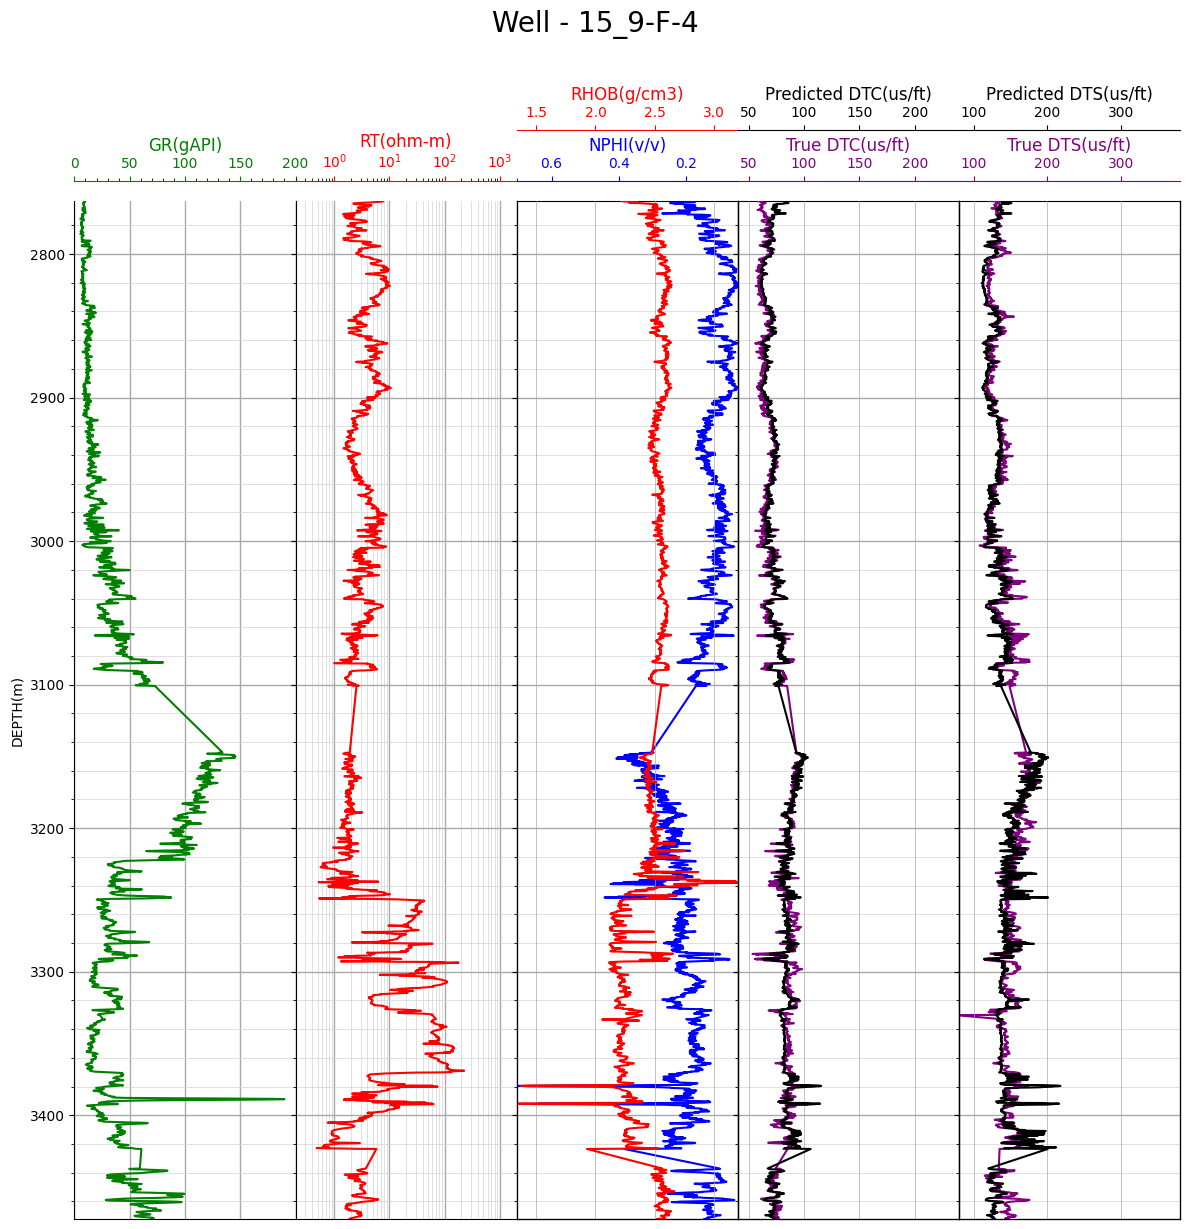

In [159]:
make_log_plot(well5_new, 'GR', 'RT', 'NPHI', 'RHOB', 'DTC', 'Predicted DTC', 'DTS', 'Predicted DTS', '15_9-F-4')